In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import networkx as nx
import dgl

import sys
sys.path.append('..')
from arch import *
from arch_noDGL import IOGCNH


import pytorch_lightning as pl

from utils.mesh_utils import plot_field, get_mesh_graph, quad2tri

/home/vtenorio/.local/lib/python3.8/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/vtenorio/.local/lib/python3.8/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/vtenorio/.local/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# IO-GNN

In [3]:
input_data = "mydata/xcoarse_data"
data = np.load(input_data + "/proc_data.npz")
S_coarse = data["adj"]
data_coarse = data["data"]
feat_names = list(data["feat_names"])

In [4]:
output_data = "mydata/fine_data"
data = np.load(output_data + "/proc_data.npz")
S_fine = data["adj"]
data_fine = data["data"]
feat_names = list(data["feat_names"])

In [5]:
data_coarse.shape, data_fine.shape

((11550, 353, 15), (11550, 6684, 15))

In [6]:
# Drop PointID
if "PointID" in feat_names:
    del feat_names[0]
    data_coarse = data_coarse[:,:,1:]
    data_fine = data_fine[:,:,1:]

In [7]:
feat_names

['x',
 'y',
 'Density',
 'Momentum_x',
 'Momentum_y',
 'Energy',
 'Pressure',
 'Temperature',
 'Mach',
 'Pressure_Coefficient',
 'Vel_x',
 'Vel_y',
 'MachSimulation',
 'AoA']

In [8]:
inputs = ["x", "y", "Vel_x", "Vel_y", "Pressure", "Temperature", "MachSimulation", "AoA"]
idxs_input = [feat_names.index(l) for l in inputs]

In [9]:
labels = ["Momentum_x", "Momentum_y", "Pressure"]#["Vel_x", "Vel_y", "Pressure"]
idxs_label = [feat_names.index(l) for l in labels]

In [10]:
np.allclose(data_coarse[:,:,3] / data_coarse[:,:,2], data_coarse[:,:,10]), np.allclose(data_coarse[:,:,4] / data_coarse[:,:,2], data_coarse[:,:,11])

(True, True)

In [11]:
n_timesteps = data_coarse.shape[0]
n_timesteps

11550

In [12]:
split = "paper_interpolation"
if split == "random":
    # Random time-test split
    N_train = 500
    N_test = 200
    idxs = np.random.permutation(n_timesteps)
    idxs_train = idxs[:N_train]
    idxs_test = idxs[N_train:N_train+N_test]
elif split == "consecutive":
    N_train = 500
    N_test = 200
    idxs_train = torch.arange(n_timesteps)[:N_train]
    idxs_test = torch.arange(n_timesteps)[N_train:N_train+N_test]
elif split == "paper_interpolation":
    MACH_TRAIN_LIST = [0.2, 0.3, 0.35, 0.4, 0.5, 0.55, 0.6, 0.7]#, 0.8]
    MACH_TEST_LIST = [0.25, 0.45, 0.65]
    idxs_train = np.isin(data_coarse[:,0,-2], MACH_TRAIN_LIST)
    idxs_test = np.isin(data_coarse[:,0,-2], MACH_TEST_LIST)
    N_train = idxs_train.sum()
    N_test = idxs_test.sum()
elif split == "paper_generalization":
    idxs_train = data_coarse[:,0,-2] <= 0.5
    idxs_test = data_coarse[:,0,-2] > 0.5
    N_train = idxs_train.sum()
    N_test = idxs_test.sum()

In [13]:
norm_method = "MinMax"
if norm_method == "MinMax":
    data_coarse_n = (data_coarse - data_coarse.min(axis=(0,1))) / (data_coarse.max(axis=(0,1)) - data_coarse.min(axis=(0,1)))
    data_fine_n = (data_fine - data_fine.min(axis=(0,1))) / (data_fine.max(axis=(0,1)) - data_fine.min(axis=(0,1)))
elif norm_method == "Standard":
    data_coarse_n = (data_coarse - data_coarse.mean(axis=(0,1))) / data_coarse.std(axis=(0,1))
    data_fine_n = (data_fine - data_fine.mean(axis=(0,1))) / data_fine.std(axis=(0,1))
x_train2 = data_coarse_n[idxs_train,:,:]#[:,:,idxs_input]
y_train2 = data_fine_n[idxs_train,:,:][:,:,idxs_label]
x_test2 = data_coarse_n[idxs_test,:,:]#[:,:,idxs_input]
y_test2 = data_fine_n[idxs_test,:,:][:,:,idxs_label]

In [14]:
x_train = data_coarse[idxs_train,:,:]#[:,:,idxs_input]
y_train = data_fine[idxs_train,:,:][:,:,idxs_label]
x_test = data_coarse[idxs_test,:,:]#[:,:,idxs_input]
y_test = data_fine[idxs_test,:,:][:,:,idxs_label]
x_train.shape, x_test.shape

((8400, 353, 14), (3150, 353, 14))

In [15]:
norm_method = "MinMax"
if norm_method == "MinMax":
    min_feat_x = x_train.min(axis=(0,1))
    max_feat_x = x_train.max(axis=(0,1))
    min_feat_y = y_train.min(axis=(0,1))
    max_feat_y = y_train.max(axis=(0,1))
    x_train = (x_train - min_feat_x) / (max_feat_x - min_feat_x)
    y_train = (y_train - min_feat_y) / (max_feat_y - min_feat_y)
    x_test = (x_test - min_feat_x) / (max_feat_x - min_feat_x)
    y_test = (y_test - min_feat_y) / (max_feat_y - min_feat_y)
elif norm_method == "Standard":
    data_coarse_n = (data_coarse - data_coarse.mean(axis=(0,1))) / data_coarse.std(axis=(0,1))
    data_fine_n = (data_fine - data_fine.mean(axis=(0,1))) / data_fine.std(axis=(0,1))

In [16]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

In [17]:
gx_nx = nx.from_numpy_array(S_coarse)
gx = dgl.from_networkx(gx_nx).add_self_loop()
gy_nx = nx.from_numpy_array(S_fine)
gy = dgl.from_networkx(gy_nx).add_self_loop()

In [18]:
N_coarse = S_coarse.shape[0]
N_fine = S_fine.shape[0]

In [19]:
coords_coarse = data_coarse[0,:,:2]
coords_fine = data_fine[0,:,:2]
C = np.zeros((N_fine, N_coarse))
for i in range(N_fine):
    dists = ((coords_coarse - coords_fine[i,:])**2).sum(1)
    j = np.argmin(dists)
    C[i,j] = 1.

C = torch.Tensor(C)

In [20]:
lr = 5e-5
wd = 1e-10
n_epochs = 500
batch_size = 16
n_layers = 3
hid_dim = 512
eval_freq = 20
nonlin_fn = torch.nn.ReLU
K = 4

method = "transpose"

In [21]:
# define the LightningModule
class LitModel(pl.LightningModule):
    def __init__(self, model_name, in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, n_layers_y, method, n_sel, gx, gy, build_params):
        super().__init__()
        self.save_hyperparameters("model_name", "hid_dim", "n_layers_x", "n_layers_y", "method", "build_params")

        self.gx = gx.to('cuda')
        self.gy = gy.to('cuda')

        coords_coarse = data_coarse[0,:,:2]
        coords_fine = data_fine[0,:,:2]
        C = np.zeros((N_fine, N_coarse))
        for i in range(N_fine):
            dists = ((coords_coarse - coords_fine[i,:])**2).sum(1)
            js = np.argsort(dists)[:n_sel]
            C[i,js] = 1. / n_sel

        C = torch.Tensor(C).to('cuda')
        
        self.model_name = model_name

        if self.model_name == "IOGCN":
            self.model = IOGCN(in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, [], method=method, build_params=build_params, n_layers_y=n_layers_y, nonlin=nonlin_fn, C=C)
        elif self.model_name == "IOMLP":
            self.model = IOMLP(in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, [], method=method, n_layers_y=n_layers_y, nonlin=nonlin_fn, C=C)
        elif self.model_name == "IOGCNH":
            self.model = IOGCNH(torch.Tensor(S_coarse), torch.Tensor(S_fine), in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, n_layers_y, K=K, idxs=[], method=method, nonlin=nonlin_fn, C=C)
        elif self.model_name == "IOGAT":
            self.model = IOGAT(in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, [], method=method, build_params=build_params, n_layers_y=n_layers_y, nonlin=nonlin_fn, C=C)

        else:
            raise NotImplementedError()
        
        self.n_layers_x = n_layers_x
        self.n_layers_y = n_layers_y
        self.hid_dim = hid_dim
        self.method = method
        self.n_sel = n_sel

        self.loss_fn = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        
        y_hat = self.model(self.gx, self.gy, x)
        loss = self.loss_fn(y_hat, y)
        
        self.train_loss.append(loss.item())
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = val_batch
        y_hat = self.model(self.gx, self.gy, x)
        loss = self.loss_fn(y_hat, y)
        # Logging to TensorBoard by default
        
        self.validation_loss.append(loss.item())

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(self.gx, self.gy, x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("test_mse", loss)
        self.log("test_rmse", torch.sqrt(loss))
        
    def on_train_epoch_start(self):
        self.train_loss = []
        
    def on_train_epoch_end(self):
        avg_loss = np.mean(self.train_loss)

        self.log("train_mse", avg_loss)
        self.log("train_rmse", np.sqrt(avg_loss))
        
    def on_validation_epoch_start(self):
        self.validation_loss = []
        
    def on_validation_epoch_end(self):
        avg_loss = np.mean(self.validation_loss)

        self.log("val_mse", avg_loss)
        self.log("val_rmse", np.sqrt(avg_loss))
        
    def on_train_start(self):
        self.loggers[1].log_hyperparams({"model": self.model_name,
                                         "split": split,
                                         "N_train": N_train,
                                         "lr": lr,
                                         "batch_size": batch_size,
                                         "n_sel": self.n_sel,
                                         "method": self.method,
                                         "n_layers_x": self.n_layers_x,
                                         "n_layers_y": self.n_layers_y,
                                         "hid_dim": self.hid_dim
                                       })

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        return optimizer
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x,y=batch
        return self(x)
    
    def forward(self, x):
        return self.model(self.gx, self.gy, x)

In [22]:
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

In [23]:
in_dim = x_train.shape[2]
out_dim = len(labels)

In [24]:
def test_model(in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, n_layers_y, method, n_sel, model_name, build_params, experiment_name):
    #early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_mse", min_delta=0.00, patience=50, verbose=False, mode="min")
    tb_logger = pl.loggers.TensorBoardLogger("tblogs", name=f"{experiment_name}/{model_name}", default_hp_metric=False)
    mlf_logger = pl.loggers.MLFlowLogger(experiment_name=experiment_name)
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=n_epochs,
        #callbacks=[early_stop_callback],
        logger=[tb_logger,mlf_logger],
        enable_checkpointing=False,
        #profiler="simple"
    )
    
    pl_model = LitModel(model_name, in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers_x, n_layers_y, method, n_sel, gx, gy, build_params)
    
    trainer.fit(pl_model, dataloader_train)

    trainer.test(pl_model, dataloaders=dataloader_test)
    
    return trainer.predict(pl_model, dataloader_test)

In [25]:
build_params= {'norm': 'both'}
y_hat_io = test_model(in_dim, 32, out_dim, N_coarse, N_fine, 2, 4, "linear", -1, "IOGCN", build_params, "TestingForFigure")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/vtenorio/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | model   | IOGCN   | 2.4 M 
1 | loss_fn | MSELoss | 0     
------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.457     Total estimated model params size (MB)
/home/vtenorio/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/vtenorio/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/vtenorio/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │   7.000828918535262e-05   │
│         test_rmse         │   0.007919149473309517    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/vtenorio/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 412it [00:00, ?it/s]

In [51]:
iomlp_model = IOMLP(in_dim, hid_dim, out_dim, N_coarse, N_fine, n_layers, [], method, nonlin=nonlin_fn)
y_hat_iomlp = test_model(iomlp_model, "IOMLP")
#y_hat_iomlp = iomlp_model(gx, gy, x_test).squeeze().cpu().detach().numpy()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | model   | IOMLP   | 4.1 M 
1 | loss_fn | MSELoss | 0     
------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.579    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 357it [00:00, ?it/s]

# Representation

In [26]:
nodes, edges, elems, marker_dict = get_mesh_graph(f"mydata/fine_data/mesh_NACA0012_fine.su2")

(-1.0, 1.0)

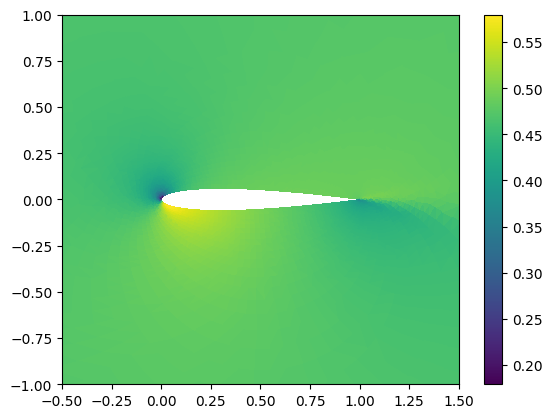

In [27]:
elems_list = sum(elems, [])
tris, _ = quad2tri(elems_list)
tris = np.array(tris)
x, y = nodes[:,0], nodes[:,1]
field = y_test[0,:,0].cpu().numpy()

fig = plt.figure()
plt.tripcolor(x, y, tris, field)
plt.colorbar()

plt.xlim(left=-0.5, right=1.5)
plt.ylim(bottom=-1, top=1)

Text(0.5, 1.0, 'IOGCN Prediction')

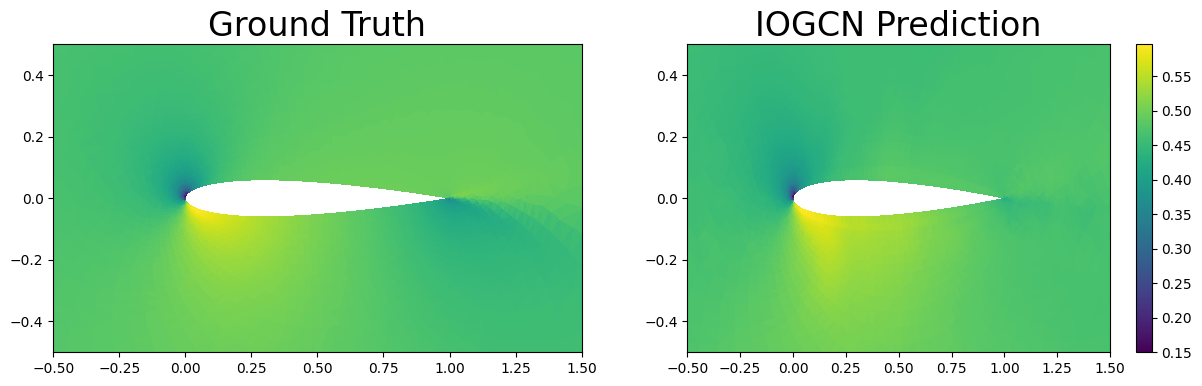

In [28]:
field_gt = y_test[0,:,0].cpu().numpy()
field_io = y_hat_io[0][0,:,0]

fig, ax = plt.subplots(1, 2, figsize=(15,4))
im0 = ax[0].tripcolor(x, y, tris, field_gt)
im1 = ax[1].tripcolor(x, y, tris, field_io)

fig.colorbar(im1)

ax[0].set_xlim(left=-0.5, right=1.5)
ax[1].set_xlim(left=-0.5, right=1.5)
ax[0].set_ylim(bottom=-0.5, top=0.5)
ax[1].set_ylim(bottom=-0.5, top=0.5)

ax[0].set_title("Ground Truth", fontsize=24)
ax[1].set_title("IOGCN Prediction", fontsize=24)

(-1.0, 1.0)

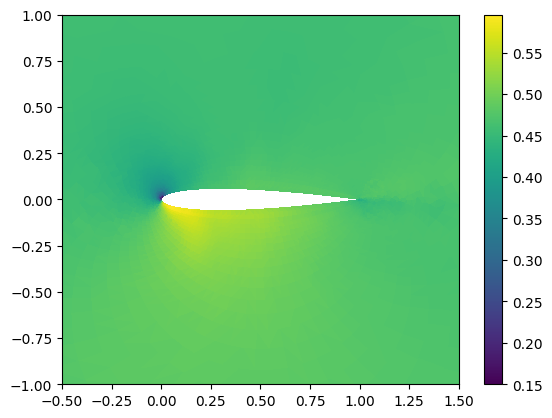

In [29]:
elems_list = sum(elems, [])
tris, _ = quad2tri(elems_list)
tris = np.array(tris)
x, y = nodes[:,0], nodes[:,1]
field = y_hat_io[0][0,:,0]

fig = plt.figure()
plt.tripcolor(x, y, tris, field)
plt.colorbar()

plt.xlim(left=-0.5, right=1.5)
plt.ylim(bottom=-1, top=1)